# Urban Flood Forecasting - Method 1: Markov Chain Approach
**Objective:** Build a probabilistic Markov Chain model for urban flood prediction.

**Approach:**
1. Discretizes water levels into states (bins).
2. Learns transition probabilities between states.
3. Uses rainfall as observation/forcing signal.
4. Predicts future water level states autoregressively.

In [2]:
import numpy as np
import pandas as pd
import os
import glob
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')

In [3]:
# Base directory
BASE_DIR = Path(r"c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\Models")
MODEL_1_DIR = BASE_DIR / "Model_1"

# Output directory
OUTPUT_DIR = Path(r"c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\method1_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Model Directory: {MODEL_1_DIR}")

Model Directory: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\Models\Model_1


In [ ]:
def load_all_event_data(model_dir, subset_events=None):
    """
    Loads data from all event folders.
    Returns dictionaries of dataframes for 1D and 2D nodes.
    """
    train_dir = model_dir / "train"
    event_folders = sorted([f for f in train_dir.iterdir() if f.is_dir() and f.name.startswith('event_')])
    
    if subset_events:
        event_folders = [f for f in event_folders if f.name in subset_events]
    
    data_store = {
        '1d_water_levels': {}, # event_name -> df [timesteps, nodes]
        '2d_water_levels': {}, 
        '2d_rainfall': {}
    }
    
    print(f"Loading {len(event_folders)} events...")
    
    for folder in tqdm(event_folders):
        event_name = folder.name
        
        # Load 1D dynamic data
        df_1d = pd.read_csv(folder / "1d_nodes_dynamic_all.csv")
        # Pivoting to get [timesteps, nodes]
        df_1d_pivot = df_1d.pivot(index='timestep', columns='node_idx', values='water_level')
        data_store['1d_water_levels'][event_name] = df_1d_pivot
        
        # Load 2D dynamic data
        df_2d = pd.read_csv(folder / "2d_nodes_dynamic_all.csv")
        df_2d_pivot_wl = df_2d.pivot(index='timestep', columns='node_idx', values='water_level')
        df_2d_pivot_rain = df_2d.pivot(index='timestep', columns='node_idx', values='rainfall')
        
        data_store['2d_water_levels'][event_name] = df_2d_pivot_wl
        data_store['2d_rainfall'][event_name] = df_2d_pivot_rain
        
    return data_store

# Load ALL events for Competition Submission
train_events_list = sorted([f.name for f in (MODEL_1_DIR / "train").iterdir() if f.is_dir() and f.name.startswith('event_')])
print(f"Total available events: {len(train_events_list)}")

data_store = load_all_event_data(MODEL_1_DIR, subset_events=train_events_list)

Loading 8 events...


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


In [5]:
class MarkovChainFloodPredictor:
    def __init__(self, n_states=30, n_rainfall_bins=5):
        self.n_states = n_states
        self.n_rainfall_bins = n_rainfall_bins
        self.transition_probs = {}  # {(node_idx, rainfall_bin): transition_matrix}
        self.state_edges = {}  # node_idx -> bin edges
        self.rainfall_edges = None # Global rainfall edges
        
    def _bin_rainfall(self, rainfall_values):
        """Discretize rainfall values into bins"""
        if self.rainfall_edges is None:
             # Calculate global quantiles if not set
             pass
        
        return np.digitize(rainfall_values, self.rainfall_edges) - 1
        
    def fit(self, water_levels_dict, rainfall_dict, node_type='1d'):
        """
        Fits the Markov Chain for all nodes of a specific type.
        
        water_levels_dict: {event_name: df[timesteps, nodes]}
        rainfall_dict: {event_name: df[timesteps, nodes]} (for 2D) or None (for 1D)
        """
        print(f"Training Markov Chain for {node_type} nodes...")
        
        # Concatenate all events for determining bins
        all_wl = pd.concat(water_levels_dict.values(), axis=0)
        
        if node_type == '2d':
            all_rain = pd.concat(rainfall_dict.values(), axis=0)
            # Global rainfall bins
            # Use only positive rainfall for quantiles to avoid skew from zeros
            rain_values = all_rain.values.flatten()
            rain_pos = rain_values[rain_values > 0]
            if len(rain_pos) > 0:
                self.rainfall_edges = np.quantile(rain_values, np.linspace(0, 1, self.n_rainfall_bins+1))
                self.rainfall_edges = np.unique(self.rainfall_edges)
                if len(self.rainfall_edges) < self.n_rainfall_bins + 1:
                     max_r = rain_values.max()
                     self.rainfall_edges = np.linspace(0, max_r, self.n_rainfall_bins+1)
            else:
                 self.rainfall_edges = np.array([0.0, 1.0]) # Dummy
            
            self.rainfall_edges[0] = -np.inf
            self.rainfall_edges[-1] = np.inf
            
        else:
             if rainfall_dict is not None:
                all_rain = pd.concat(rainfall_dict.values(), axis=0)
                rain_values = all_rain.values.flatten()
                self.rainfall_edges = np.quantile(rain_values, np.linspace(0, 1, self.n_rainfall_bins+1))
                self.rainfall_edges[0] = -np.inf
                self.rainfall_edges[-1] = np.inf
        
        nodes = all_wl.columns
        
        for node_idx in tqdm(nodes):
            # Discretize water levels for this node
            node_wl = all_wl[node_idx].values
            
            try:
                edges = np.quantile(node_wl, np.linspace(0, 1, self.n_states+1))
                edges = np.unique(edges)
                if len(edges) < 2:
                    edges = np.array([node_wl.min(), node_wl.max() + 0.1])
            except:
                edges = np.linspace(node_wl.min(), node_wl.max(), self.n_states+1)
                
            edges[0] = -np.inf
            edges[-1] = np.inf
            self.state_edges[node_idx] = edges
            
            # Initialize transition counts
            actual_rain_bins = self.n_rainfall_bins if rainfall_dict is not None else 1
            counts = {r: np.zeros((len(edges)-1, len(edges)-1)) for r in range(actual_rain_bins)}
            
            # Count transitions
            for event_name, df_wl in water_levels_dict.items():
                wl_seq = df_wl[node_idx].values
                states = np.digitize(wl_seq, edges) - 1
                states = np.clip(states, 0, len(edges)-2)
                
                if rainfall_dict is not None:
                    rain_seq = rainfall_dict[event_name].values
                    if len(rain_seq.shape) > 1:
                         if node_idx in rainfall_dict[event_name].columns:
                             rain_seq = rainfall_dict[event_name][node_idx].values
                         else:
                             rain_seq = rainfall_dict[event_name].mean(axis=1).values
                    
                    rain_bins = self._bin_rainfall(rain_seq)
                    rain_bins = np.clip(rain_bins, 0, actual_rain_bins-1)
                else:
                    rain_bins = np.zeros(len(wl_seq), dtype=int)
                
                for t in range(len(states) - 1):
                    s_current = states[t]
                    s_next = states[t+1]
                    r_bin = rain_bins[t]
                    counts[r_bin][s_current, s_next] += 1
            
            # Normalize
            for r in counts:
                counts[r] += 1e-5 
                probs = counts[r] / counts[r].sum(axis=1, keepdims=True)
                self.transition_probs[(node_idx, r)] = probs

    def predict(self, initial_state_val, rainfall_sequence, node_idx):
        edges = self.state_edges[node_idx]
        n_bins = len(edges) - 1
        
        current_state = np.digitize([initial_state_val], edges)[0] - 1
        current_state = np.clip(current_state, 0, n_bins-1)
        
        predictions = []
        
        rain_bins = self._bin_rainfall(rainfall_sequence)
        rain_bins = np.clip(rain_bins, 0, self.n_rainfall_bins-1)
        
        for r_bin in rain_bins:
            try:
                probs = self.transition_probs[(node_idx, r_bin)][current_state]
                next_state = np.argmax(probs)
            except KeyError:
                next_state = current_state
            
            val = (edges[next_state] + edges[next_state+1]) / 2
            if np.isinf(val):
                if edges[next_state] == -np.inf: val = edges[next_state+1]
                elif edges[next_state+1] == np.inf: val = edges[next_state]
            
            predictions.append(val)
            current_state = next_state
            
        return np.array(predictions)

In [6]:
# Initialize Model
model_2d = MarkovChainFloodPredictor(n_states=20, n_rainfall_bins=3)

# Filter 2D Data for a few nodes to demonstrate
all_nodes_2d = data_store['2d_water_levels'][TRAIN_EVENTS[0]].columns
nodes_to_train = all_nodes_2d[:10]

# Using the class properly:
# Create subset dictionaries
subset_wl_2d = {k: v[nodes_to_train] for k, v in data_store['2d_water_levels'].items()}
subset_rain_2d = {k: v[nodes_to_train] for k, v in data_store['2d_rainfall'].items()}

model_2d.fit(subset_wl_2d, subset_rain_2d, node_type='2d')

Training Markov Chain for 2d nodes...


100%|██████████| 10/10 [00:00<00:00, 532.77it/s]


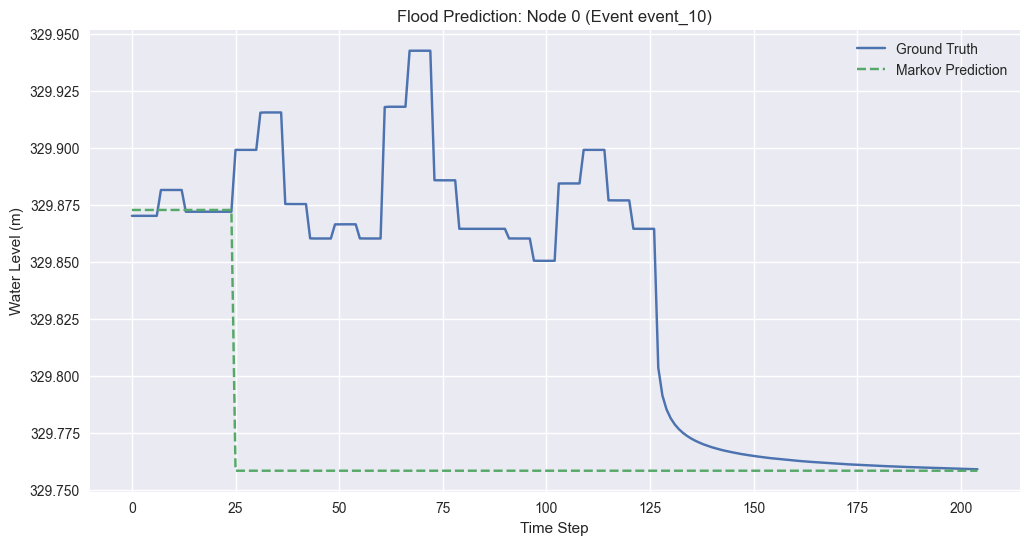

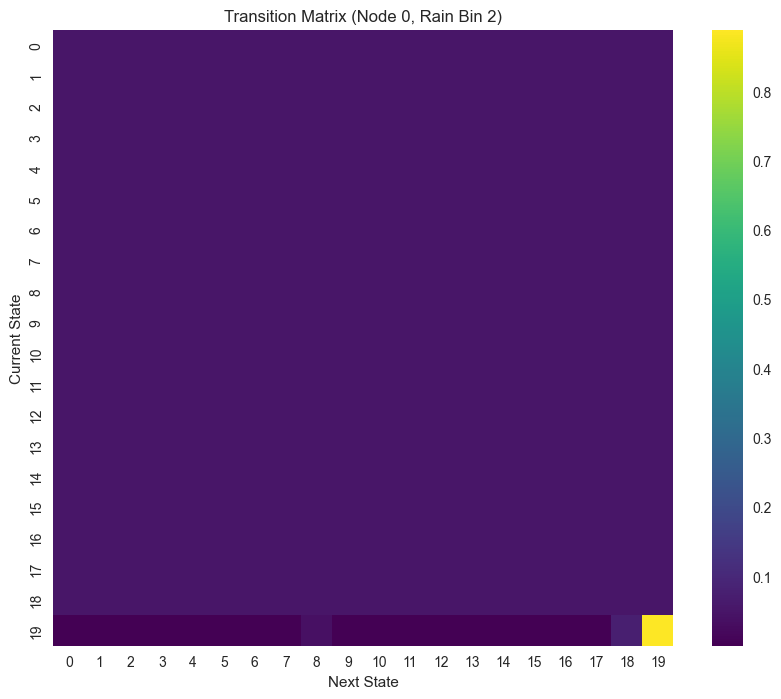

In [7]:
# Pick a test event (one of the train events for sanity check, or a new one)
test_event = TRAIN_EVENTS[-1]
node_idx = nodes_to_train[0]

# Get GT
gt_wl = data_store['2d_water_levels'][test_event][node_idx].values
rain_seq = data_store['2d_rainfall'][test_event][node_idx].values

# Predict
# Start with true initial
pred_wl = model_2d.predict(gt_wl[0], rain_seq, node_idx)

# Adjust length (predict sequence matches rain sequence length)
# Compare
plt.figure(figsize=(12, 6))
plt.plot(gt_wl, label='Ground Truth')
plt.plot(pred_wl, label='Markov Prediction', linestyle='--')
plt.title(f"Flood Prediction: Node {node_idx} (Event {test_event})")
plt.xlabel("Time Step")
plt.ylabel("Water Level (m)")
plt.legend()
plt.show()

# Visualize Transition Matrix
import seaborn as sns
states = model_2d.n_states
# Get matrix for "High Rain" bin (e.g., bin 2)
rain_bin_idx = 2
if (node_idx, rain_bin_idx) in model_2d.transition_probs:
    mat = model_2d.transition_probs[(node_idx, rain_bin_idx)]
    plt.figure(figsize=(10, 8))
    sns.heatmap(mat, cmap='viridis')
    plt.title(f"Transition Matrix (Node {node_idx}, Rain Bin {rain_bin_idx})")
    plt.xlabel("Next State")
    plt.ylabel("Current State")
    plt.show()
else:
    print("Rain bin not found in transitions")